In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import pearsonr, zscore
from scipy import stats



import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")
sample = pd.read_csv("C:/Users/arnov/Desktop/Projet/Kaggel/dw crypto/drw-crypto-market-prediction/sample_submission.csv")

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain preview:")
print(train.head())

print("\nTrain types:")
print(train.dtypes)

print("\nTrain missing values:")
print(train.isnull().sum())


Train shape: (525887, 896)
Test shape: (538150, 896)

Train preview:
                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   

                           X2        X3        X4        X5  ...      X882  \
timestamp                                                    ...             
2023-03-01 00:00:00 -0.417690  0.005399  0.125948  0.058359  ...  1.925423   
2023-03-01 00:01:00 -0.049576  0.356667  0.481087  0.237954  ...  1.928569   
2023-03-01 00:02:00 -0.291212  0.083138  0.206881  0.101727  ... 

In [4]:
print(type(train.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [5]:
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [6]:
train.isnull().sum()

bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
           ..
X887        0
X888        0
X889        0
X890        0
label       0
Length: 896, dtype: int64

In [7]:
test.isnull().sum()

bid_qty     0
ask_qty     0
buy_qty     0
sell_qty    0
volume      0
           ..
X887        0
X888        0
X889        0
X890        0
label       0
Length: 896, dtype: int64

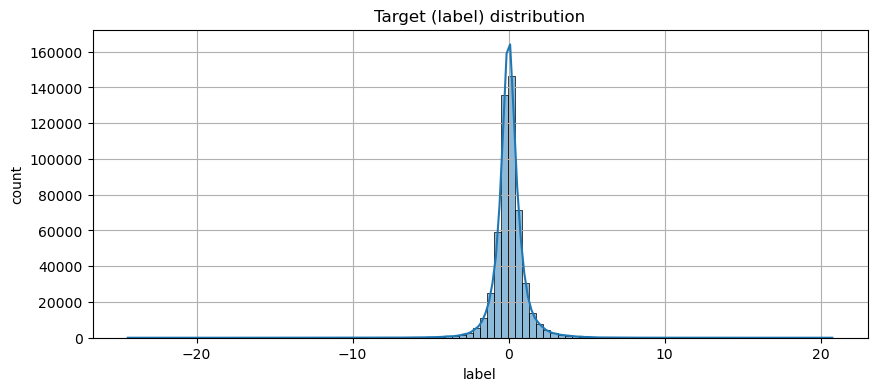

Min: -24.416614942740008 | Max: 20.74027012098192
Mean: 0.036125998833110504 | Std: 1.0099135624525448


In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(train["label"], bins=100, kde=True)
plt.title("Target (label) distribution")
plt.xlabel("label")
plt.ylabel("count")
plt.grid(True)
plt.show()

print("Min:", train["label"].min(), "| Max:", train["label"].max())
print("Mean:", train["label"].mean(), "| Std:", train["label"].std())

array([[<Axes: title={'center': 'bid_qty'}>,
        <Axes: title={'center': 'ask_qty'}>],
       [<Axes: title={'center': 'buy_qty'}>,
        <Axes: title={'center': 'sell_qty'}>],
       [<Axes: title={'center': 'volume'}>, <Axes: >]], dtype=object)

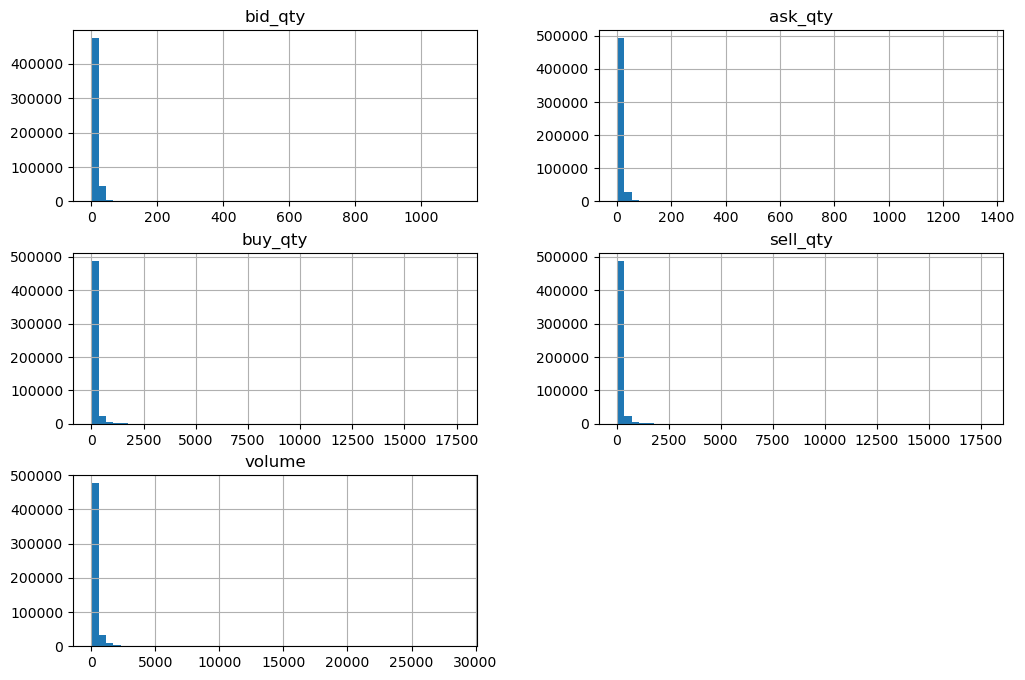

In [9]:
features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
train[features].hist(bins=50, figsize=(12, 8))

In [14]:
def visualize_target_distribution(df, target_col='label'):
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in the dataset.")
        return

    y = df[target_col]

    # --- First group of plots ---
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Histogram + KDE
    sns.histplot(y, bins=40, kde=True, color='steelblue', ax=axs[0, 0])
    axs[0, 0].axvline(y.mean(), color='crimson', linestyle='dashed', label=f'Mean = {y.mean():.3f}')
    axs[0, 0].axvline(y.median(), color='forestgreen', linestyle='dashed', label=f'Median = {y.median():.3f}')
    axs[0, 0].set_title("Target Value Distribution")
    axs[0, 0].legend()

    # 2. Boxplot
    sns.boxplot(x=y, color='salmon', ax=axs[0, 1])
    axs[0, 1].set_title("Boxplot of Target")

    # 3. Q-Q plot
    sample_for_qq = y.sample(min(5000, len(y)), random_state=0)
    stats.probplot(sample_for_qq, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title("Q-Q Plot")

    # 4. Recent time-series segment
    recent_segment = y.iloc[-min(len(y), 10000):]
    axs[1, 1].plot(recent_segment.index, recent_segment.values, color='indigo', linewidth=1)
    axs[1, 1].set_title("Recent Time Series Sample")
    axs[1, 1].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

    # --- Second group of plots ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Another histogram with precision
    sns.histplot(y, bins=50, kde=True, color='skyblue', ax=axs[0])
    axs[0].axvline(y.mean(), color='darkred', linestyle='--', label=f'Mean = {y.mean():.6f}')
    axs[0].axvline(y.median(), color='darkgreen', linestyle='--', label=f'Median = {y.median():.6f}')
    axs[0].set_title("Target Distribution w/ Annotations")
    axs[0].legend()

    # 2. Empirical CDF
    sorted_vals = np.sort(y)
    cumulative = np.linspace(0, 1, len(sorted_vals))
    axs[1].plot(sorted_vals, cumulative, color='darkorange')
    axs[1].set_title("Empirical CDF")
    axs[1].set_xlabel("Target Value")
    axs[1].set_ylabel("Cumulative Probability")

    # 3. Rolling statistics if sample size allows
    if len(y) > 1000:
        win = len(y) // 100
        roll_avg = y.rolling(window=win).mean()
        roll_std = y.rolling(window=win).std()

        plot_indices = roll_avg.index[win::win]
        mean_vals = roll_avg.values[win::win]
        std_vals = roll_std.values[win::win]

        axs[2].plot(plot_indices, mean_vals, label='Rolling Mean', color='navy')
        axs[2].fill_between(plot_indices,
                            mean_vals - std_vals,
                            mean_vals + std_vals,
                            alpha=0.3,
                            label='±1 Std Dev',
                            color='blue')
        axs[2].set_title("Rolling Mean ± Std Dev")
        axs[2].legend()
    else:
        axs[2].text(0.5, 0.5, "Not enough data for rolling stats",
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=axs[2].transAxes)
        axs[2].set_title("Rolling Statistics")

    plt.tight_layout()
    plt.show()


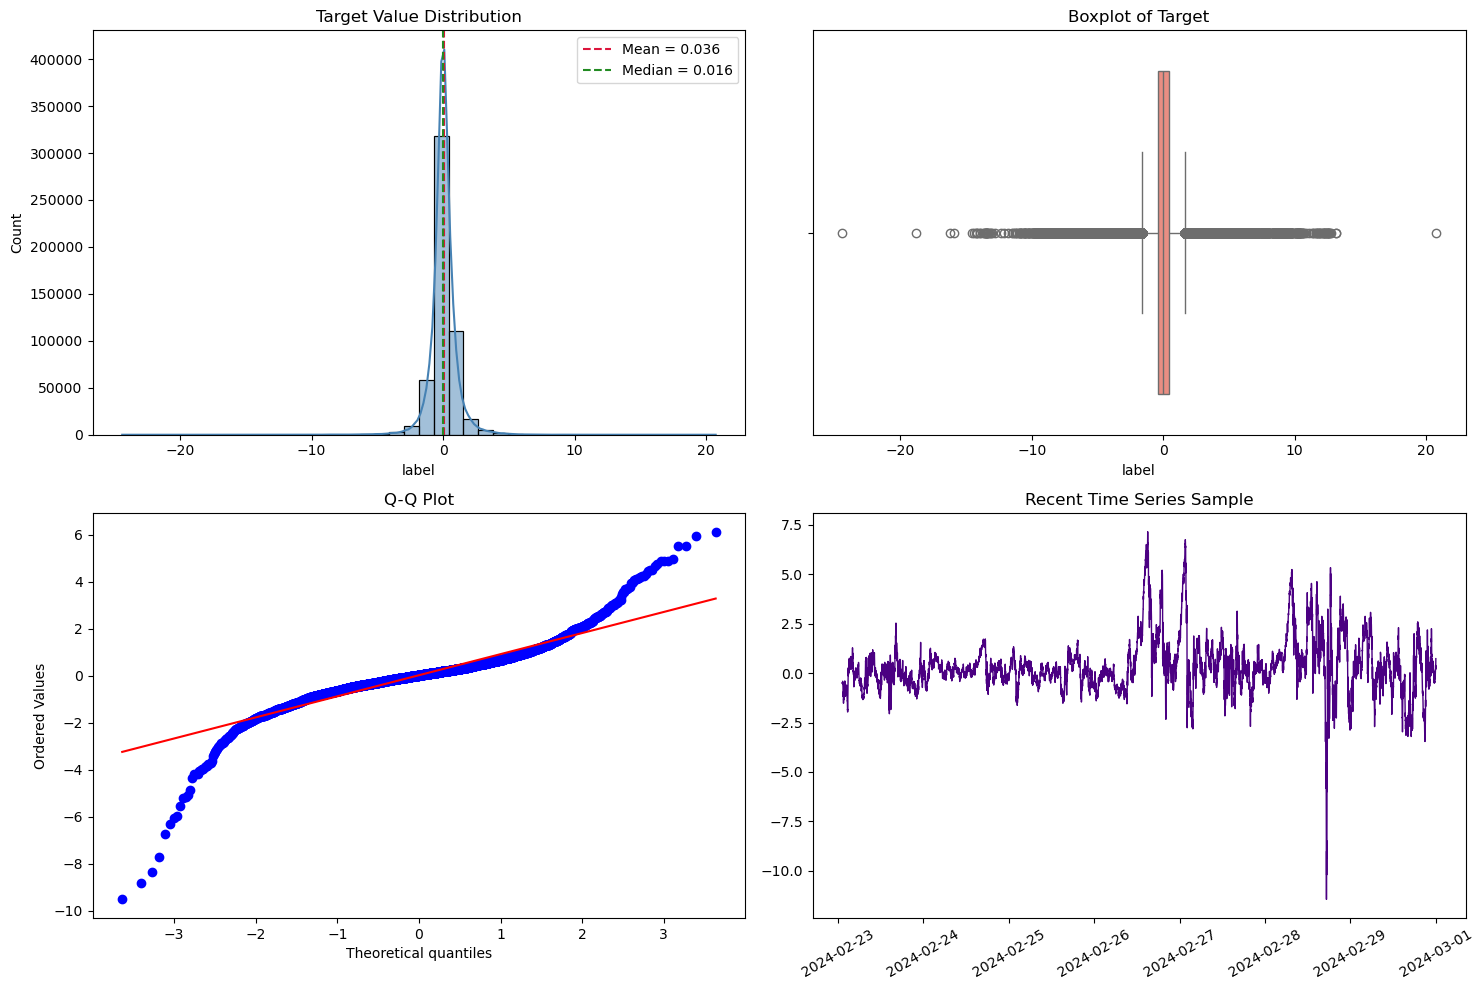

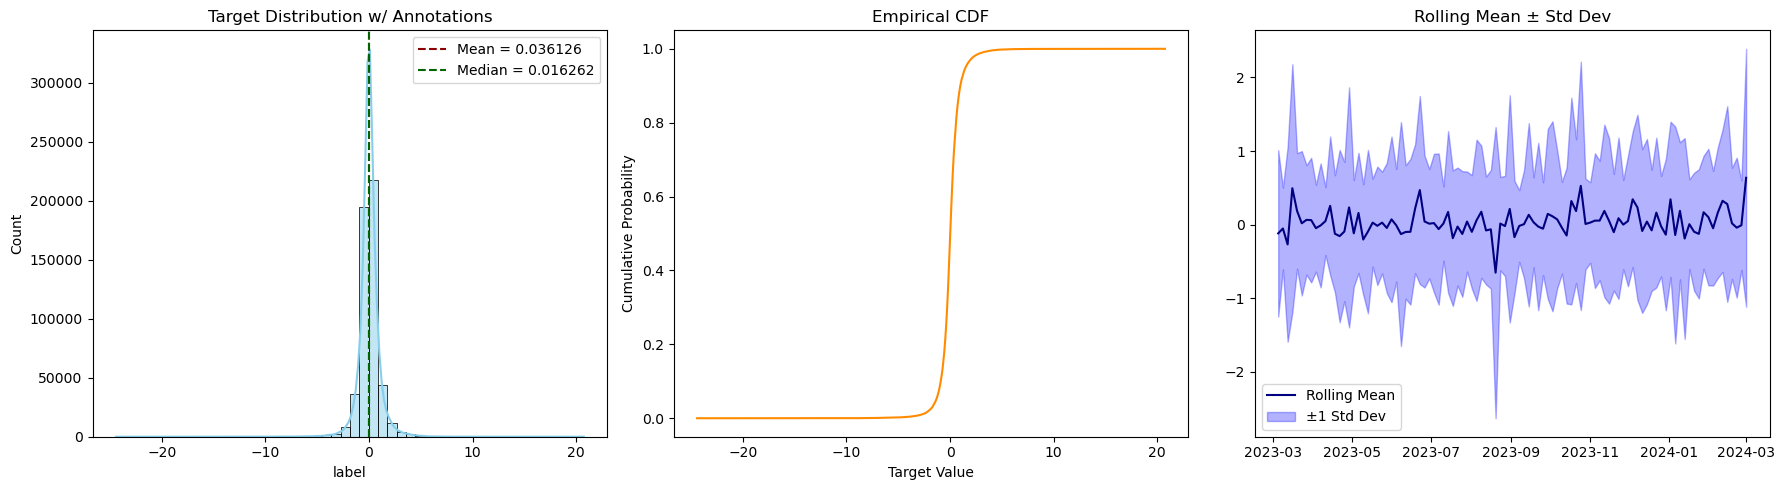

In [15]:
visualize_target_distribution(train, target_col='label')

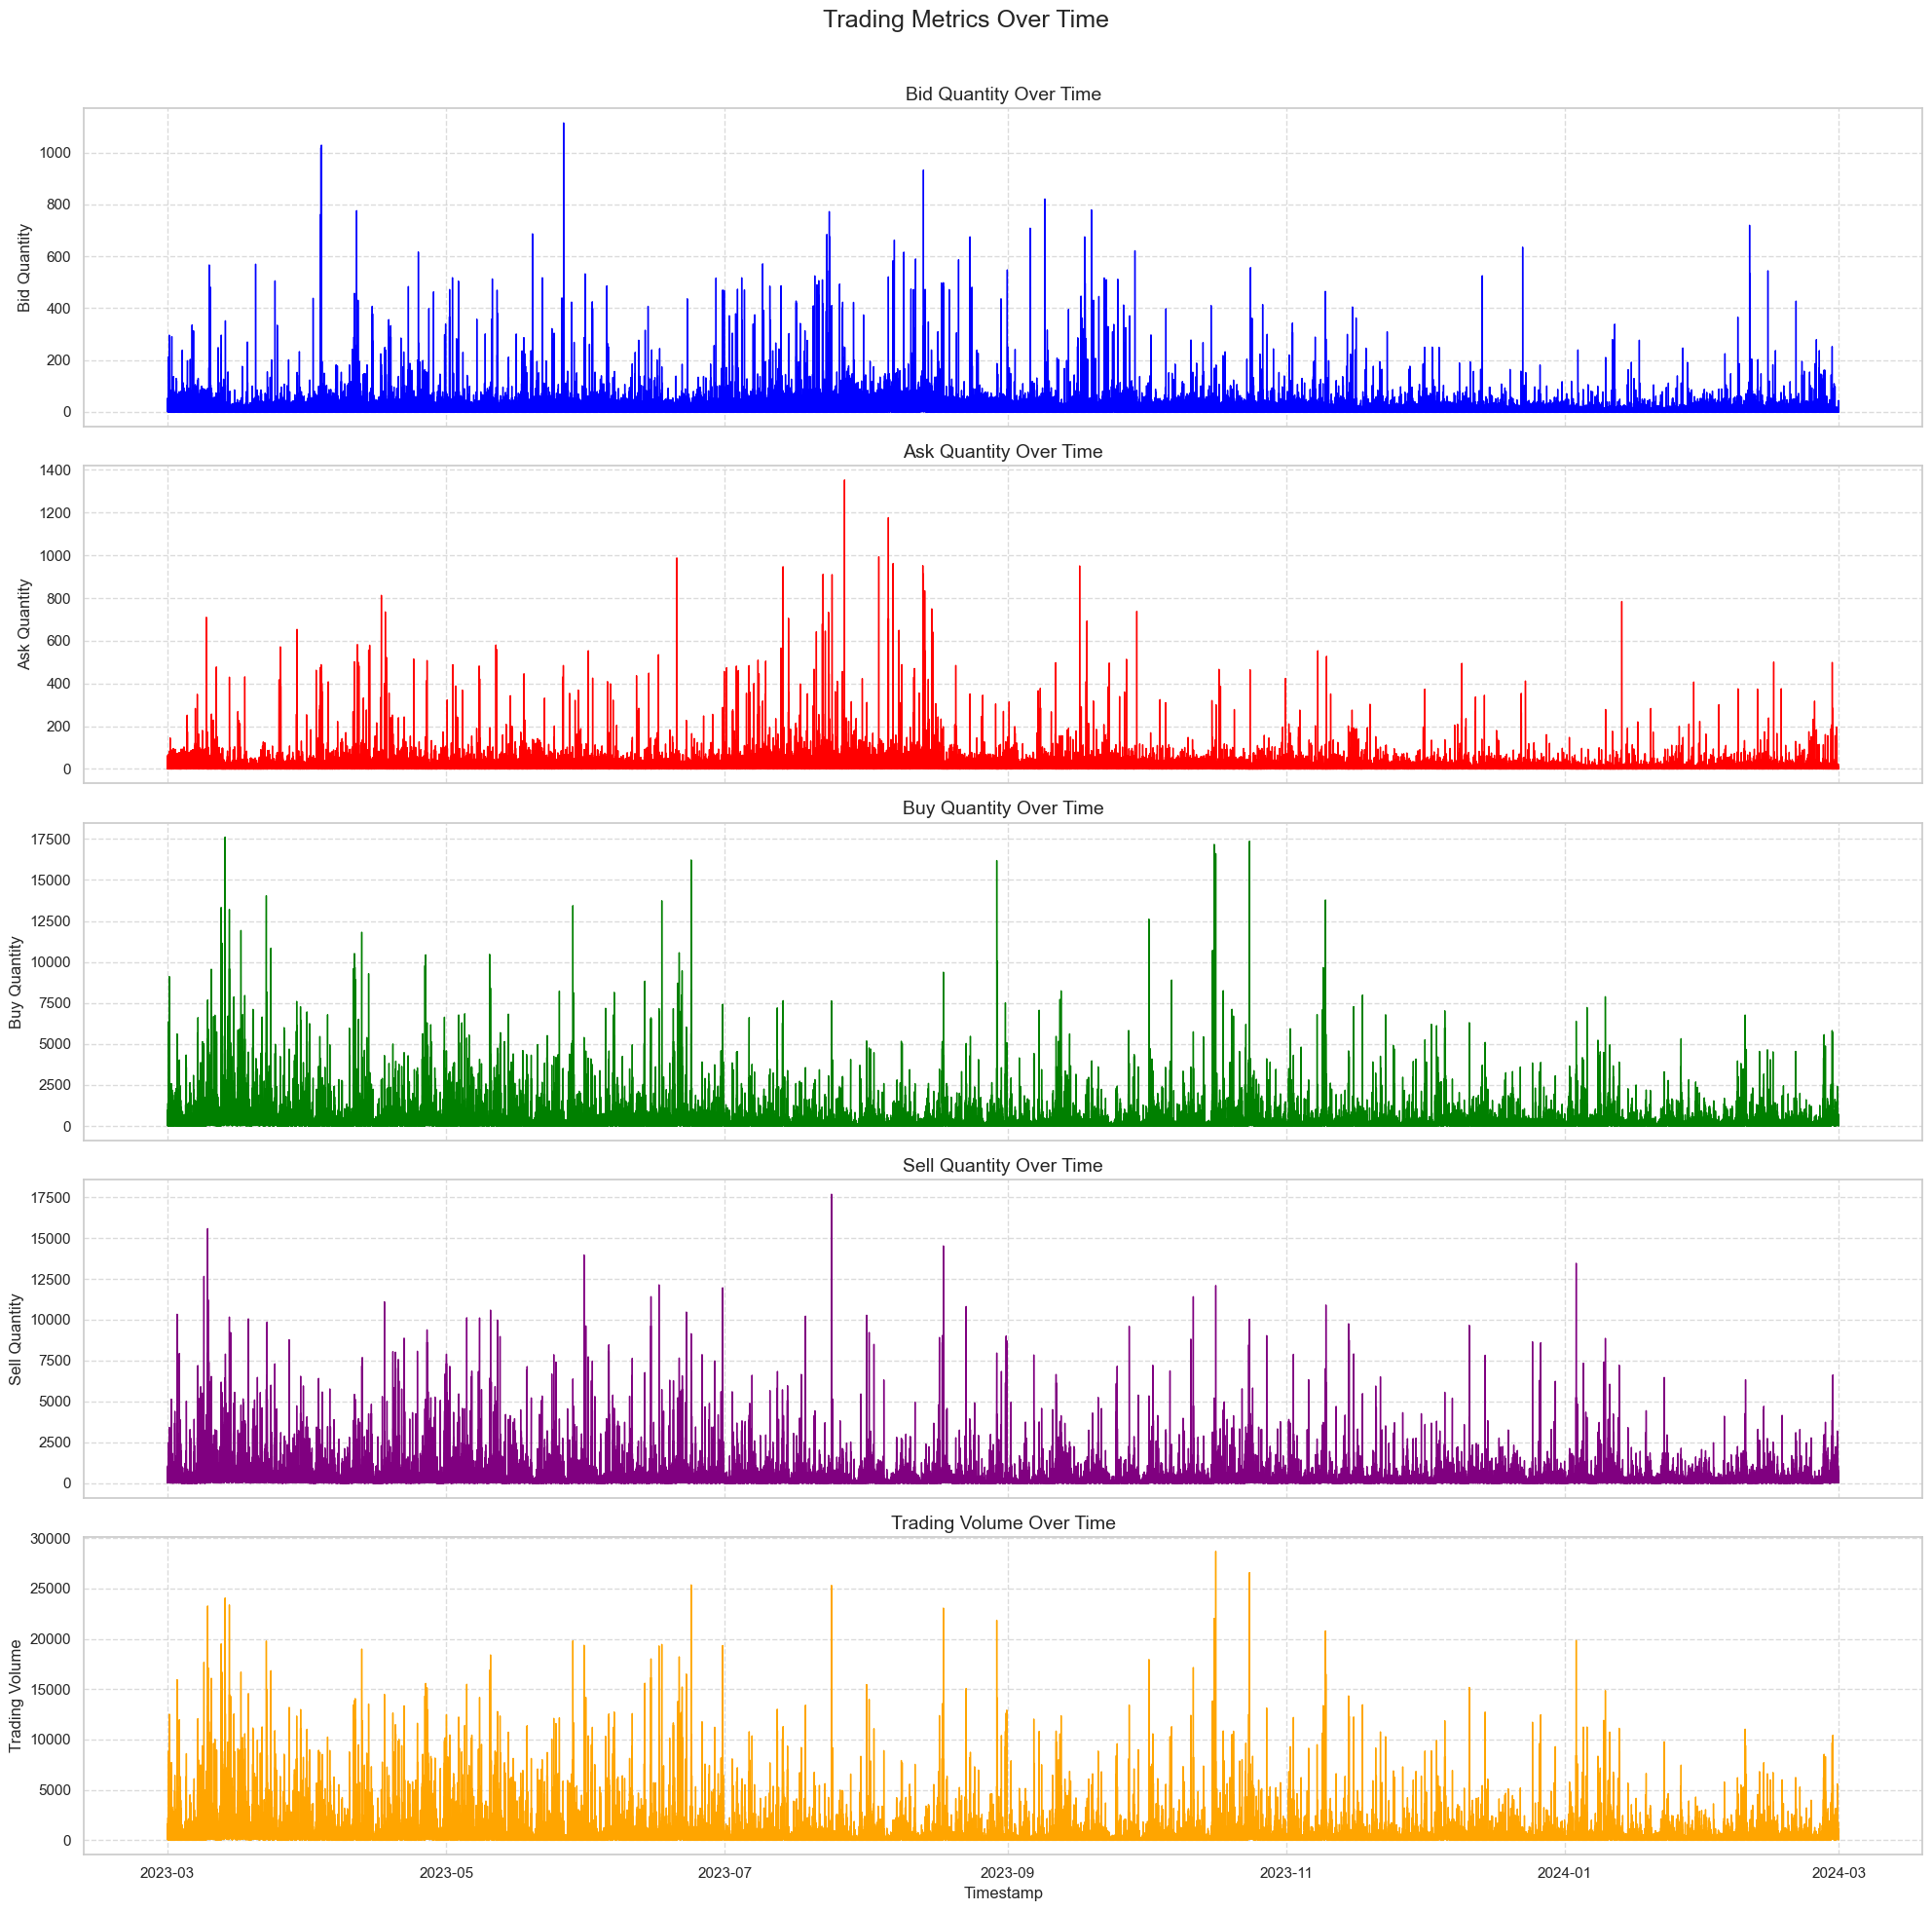

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(5, 1, figsize=(20, 20), sharex=True)
fig.suptitle("Trading Metrics Over Time", fontsize=18)

metrics = [
    ('bid_qty', 'blue', 'Bid Quantity'),
    ('ask_qty', 'red', 'Ask Quantity'),
    ('buy_qty', 'green', 'Buy Quantity'),
    ('sell_qty', 'purple', 'Sell Quantity'),
    ('volume', 'orange', 'Trading Volume'),
]

for i, (col, color, label) in enumerate(metrics):
    axes[i].plot(train.index, train[col], color=color, linewidth=1)
    axes[i].set_title(f"{label} Over Time", fontsize=14)
    axes[i].set_ylabel(label)
    axes[i].grid(True, linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Timestamp')

plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()

Text(0.5, 1.0, 'Target (Label) Over Time')

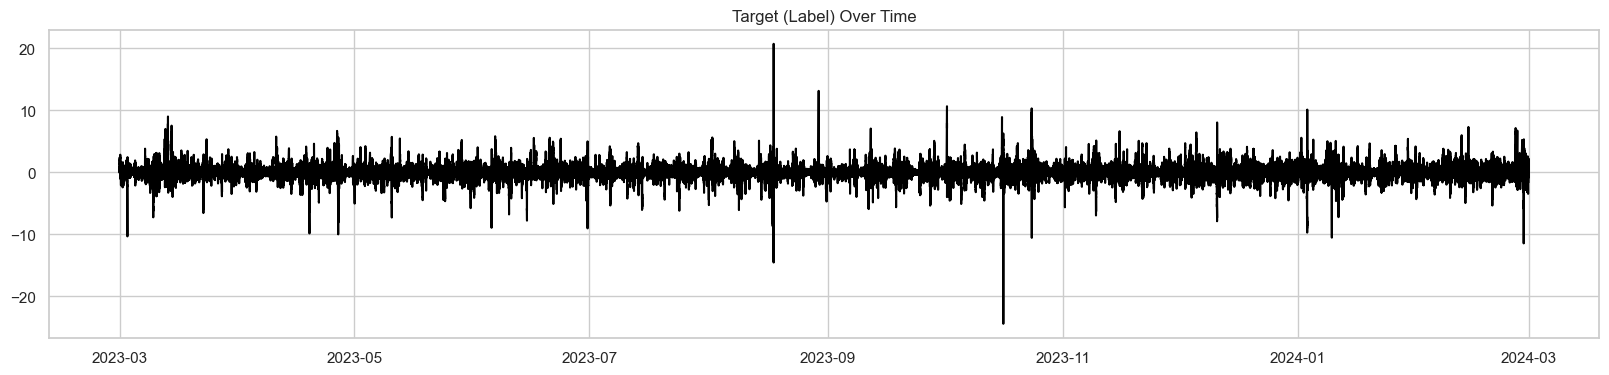

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(train.index, train['label'], color='black')
plt.title('Target (Label) Over Time')


In [ ]:
def detect_outliers(series: pd.Series, method='all', verbose=True):
    """
    Detects outliers in a numeric series using various statistical methods.
    
    Parameters:
        series (pd.Series): Input numerical series.
        method (str): 'iqr', 'zscore', 'modified_zscore', or 'all'
        verbose (bool): Whether to print detailed output
    
    Returns:
        dict: Dictionary containing outlier indices and summary stats per method.
    """
    summary = {}
    values = series.dropna()

    if verbose:
        print("\n Outlier Detection Report")
        print("=" * 50)

    if method in ['iqr', 'all']:
        q1, q3 = values.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        mask_iqr = (values < lower) | (values > upper)
        summary['iqr'] = {
            'indices': values[mask_iqr].index.tolist(),
            'count': mask_iqr.sum(),
            'percentage': mask_iqr.mean() * 100,
            'bounds': (lower, upper)
        }

        if verbose:
            print(" IQR Method")
            print(f" - Q1 = {q1:.6f}")
            print(f" - Q3 = {q3:.6f}")
            print(f" - IQR = {iqr:.6f}")
            print(f" - Bounds = ({lower:.6f}, {upper:.6f})")
            print(f" - Outliers found: {mask_iqr.sum()} ({mask_iqr.mean() * 100:.2f}%)")

    if method in ['zscore', 'all']:
        z_scores = np.abs(zscore(values))
        mask_z = z_scores > 3
        summary['zscore'] = {
            'indices': values[mask_z].index.tolist(),
            'count': mask_z.sum(),
            'percentage': mask_z.mean() * 100
        }

        if verbose:
            print("\n Z-Score Method (|z| > 3)")
            print(f" - Outliers found: {mask_z.sum()} ({mask_z.mean() * 100:.2f}%)")

    if method in ['modified_zscore', 'all']:
        median = values.median()
        mad = np.median(np.abs(values - median))
        if mad == 0:
            warnings.warn("MAD is zero; modified z-score is not defined.")
            summary['modified_zscore'] = {
                'indices': [],
                'count': 0,
                'percentage': 0.0
            }
        else:
            mz = 0.6745 * (values - median) / mad
            mask_mz = np.abs(mz) > 3.5
            summary['modified_zscore'] = {
                'indices': values[mask_mz].index.tolist(),
                'count': mask_mz.sum(),
                'percentage': mask_mz.mean() * 100
            }

            if verbose:
                print("\n Modified Z-Score Method (|mz| > 3.5)")
                print(f" - Median = {median:.6f}, MAD = {mad:.6f}")
                print(f" - Outliers found: {mask_mz.sum()} ({mask_mz.mean() * 100:.2f}%)")

    # Optional extras
    if verbose:
        print("\n Extreme Values")
        print(f" - Top 5 highest: {values.nlargest(5).values}")
        print(f" - Top 5 lowest : {values.nsmallest(5).values}")

        if 'iqr' in summary:
            lower, upper = summary['iqr']['bounds']
            cleaned = values[(values >= lower) & (values <= upper)]
            print("\n Effect of Outliers on Statistics (IQR)")
            print(f" - Mean (full): {values.mean():.6f}")
            print(f" - Mean (no outliers): {cleaned.mean():.6f}")
            print(f" - Std  (full): {values.std():.6f}")
            print(f" - Std  (no outliers): {cleaned.std():.6f}")

    return summary

In [17]:
summary_stats = detect_outliers(train['label'], method='all')


🔎 Outlier Detection Report
 IQR Method
 - Q1 = -0.381585
 - Q3 = 0.434135
 - IQR = 0.815720
 - Bounds = (-1.605165, 1.657715)
 - Outliers found: 40161 (7.64%)

 Z-Score Method (|z| > 3)
 - Outliers found: 9755 (1.85%)

 Modified Z-Score Method (|mz| > 3.5)
 - Median = 0.016262, MAD = 0.407611
 - Outliers found: 23141 (4.40%)

 Extreme Values
 - Top 5 highest: [20.74027012 13.15315439 13.13109158 12.7638137  12.68521451]
 - Top 5 lowest : [-24.41661494 -18.79794191 -16.22738996 -15.89880881 -14.5327702 ]

 Effect of Outliers on Statistics (IQR)
 - Mean (full): 0.036126
 - Mean (no outliers): 0.018422
 - Std  (full): 1.009914
 - Std  (no outliers): 0.605680


In [18]:
FEATURES = [c for c in train.columns if c != "label"]
mean_label = train["label"].mean()
std_label = train["label"].std()
outlier_threshold = 2 * std_label

outliers_mask = (train["label"].abs() > outlier_threshold)
non_outliers_mask = ~outliers_mask

print(f"Number of outliers : {outliers_mask.sum()} / {len(train)}")

Number of outliers : 25726 / 525887


In [19]:
outliers = train[outliers_mask]
non_outliers = train[non_outliers_mask]

summary_outliers = outliers[FEATURES].describe().T[["mean", "std"]]
summary_non_outliers = non_outliers[FEATURES].describe().T[["mean", "std"]]

summary_diff = summary_outliers.copy()
summary_diff["mean_non_outlier"] = summary_non_outliers["mean"]
summary_diff["mean_diff"] = summary_diff["mean"] - summary_diff["mean_non_outlier"]

summary_diff_sorted = summary_diff.sort_values("mean_diff", key=np.abs, ascending=False)

print("\nTop 10 mean differences (outliers vs. non-outliers):")
print(summary_diff_sorted[["mean", "mean_non_outlier", "mean_diff"]].head(10))



Top 10 mean differences (outliers vs. non-outliers):
                mean  mean_non_outlier   mean_diff
volume    680.396863        243.003674  437.393190
sell_qty  341.016668        121.957745  219.058923
buy_qty   339.380195        121.045928  218.334267
bid_qty     8.403689         10.048464   -1.644776
ask_qty     8.701844         10.249899   -1.548055
X879        1.911897          0.941745    0.970153
X880        1.730427          0.948695    0.781732
X877        1.157511          0.462298    0.695213
X596       -1.232132         -0.554802   -0.677330
X594        1.212297          0.562476    0.649821


Top features distinguishing outliers: ['volume', 'sell_qty', 'buy_qty', 'bid_qty', 'ask_qty']


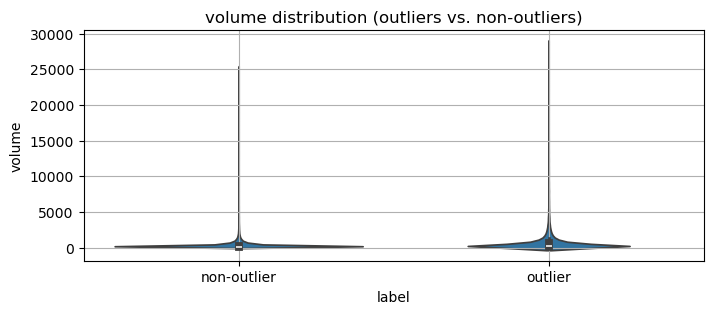

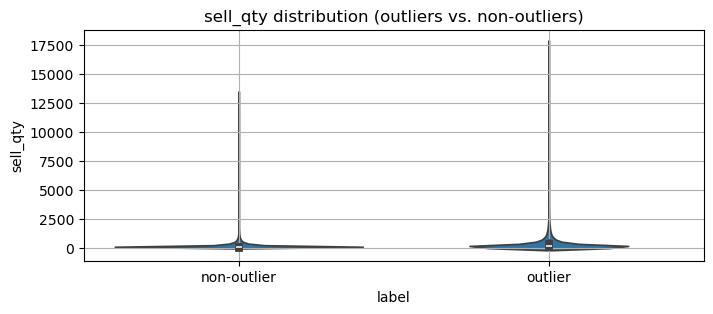

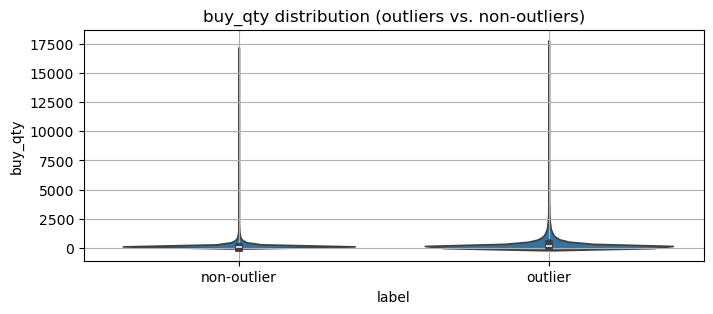

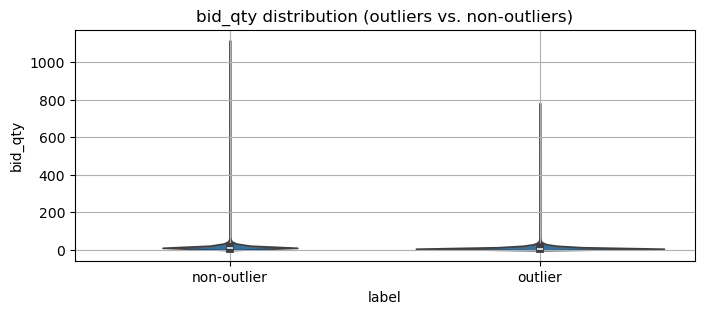

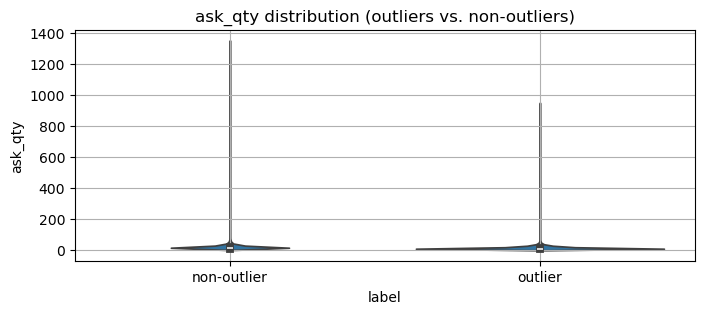

In [20]:
top_diff_features = summary_diff["mean_diff"].abs().sort_values(ascending=False).head(5).index.tolist()
print("Top features distinguishing outliers:", top_diff_features)

# Violin plots
for feat in top_diff_features:
    plt.figure(figsize=(8, 3))
    sns.violinplot(data=train, x=outliers_mask, y=feat)
    plt.title(f"{feat} distribution (outliers vs. non-outliers)")
    plt.xticks([0, 1], ["non-outlier", "outlier"])
    plt.grid(True)
    plt.show()

<Axes: >

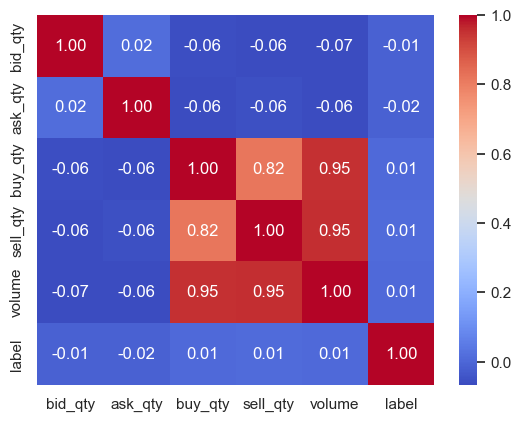

In [ ]:
subset_cols = features + ['label']
sns.heatmap(train[subset_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
focus_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'label'] + \
                 [f'X{i}' for i in range(1, 891, 5)]
focus_features = [f for f in focus_features if f in train.columns]

sample_df = train[focus_features].iloc[::10].copy()

sample_df = sample_df.loc[:, sample_df.nunique() > 1]

corrs = []
alpha = 0.05  

for i, f1 in enumerate(sample_df.columns):
    for f2 in sample_df.columns[i+1:]:
        valid = sample_df[[f1, f2]].dropna()
        if len(valid) > 10 and valid[f1].nunique() > 1 and valid[f2].nunique() > 1:
            r, p = pearsonr(valid[f1], valid[f2])
            if np.isfinite(r) and p < alpha:
                corrs.append({
                    "Feature1": f1,
                    "Feature2": f2,
                    "Correlation": r,
                    "Abs_Correlation": abs(r),
                    "P-value": p
                })

corr_df = pd.DataFrame(corrs)
top_pos = corr_df[corr_df['Correlation'] > 0].sort_values('Correlation', ascending=False).head(20)
top_neg = corr_df[corr_df['Correlation'] < 0].sort_values('Correlation').head(20)

In [ ]:
def plot_top_correlations(corr_df, title, color_palette='crest'):
    if corr_df.empty:
        print(f"No significant {title.lower()} correlations found.")
        return
    
    plt.figure(figsize=(12, 6))
    plot_df = corr_df.copy()
    plot_df['pair'] = plot_df['Feature1'] + " ~ " + plot_df['Feature2']
    
    sns.barplot(data=plot_df, y='pair', x='Correlation', palette=color_palette)
    plt.title(f"Top {len(corr_df)} {title} Correlations (p < 0.05)")
    plt.xlabel("Pearson's r")
    plt.ylabel("Feature Pairs")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

C:\Users\arnov\AppData\Local\Temp\ipykernel_21764\3014484639.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y='pair', x='Correlation', palette=color_palette)


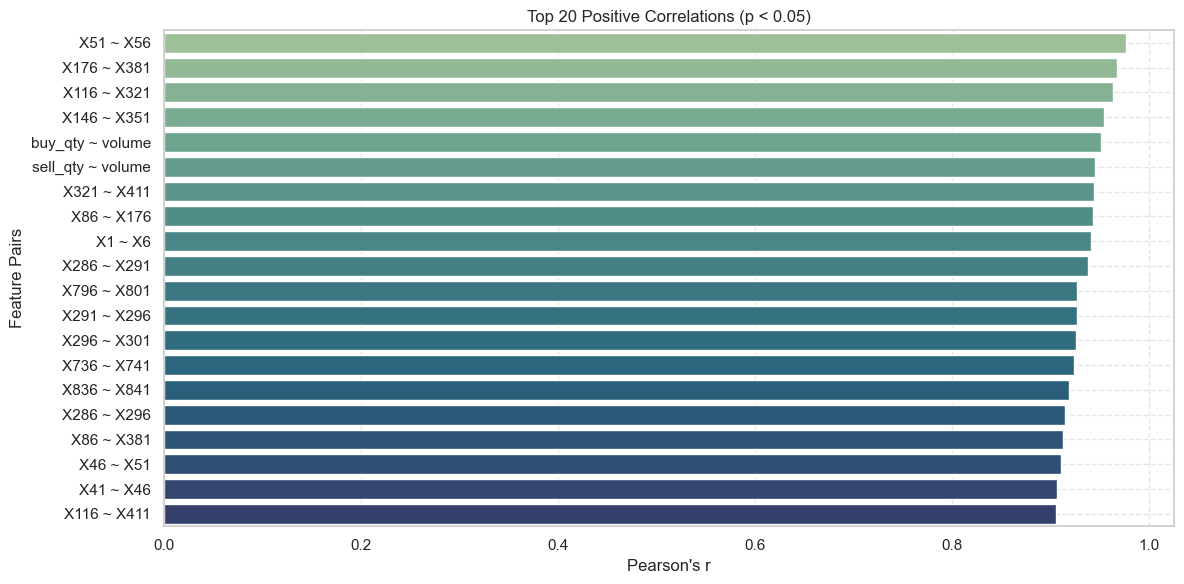

C:\Users\arnov\AppData\Local\Temp\ipykernel_21764\3014484639.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y='pair', x='Correlation', palette=color_palette)


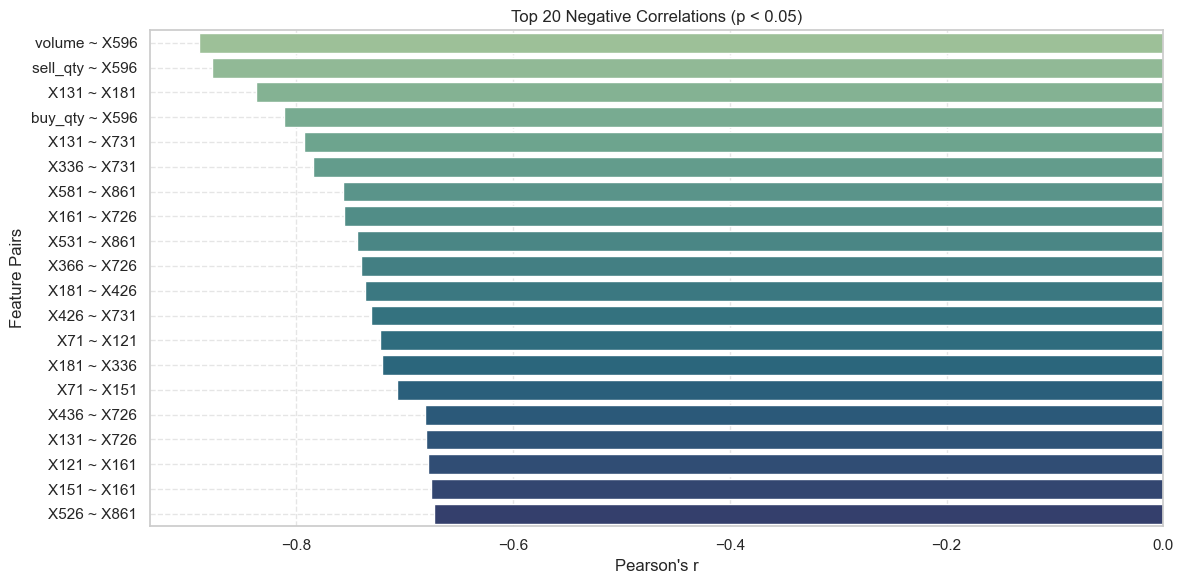

In [ ]:
plot_top_correlations(top_pos, 'Positive')
plot_top_correlations(top_neg, 'Negative')

C:\Users\arnov\AppData\Local\Temp\ipykernel_21764\254046728.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_label_df.head(20), y='Feature', x='Correlation', palette='coolwarm')


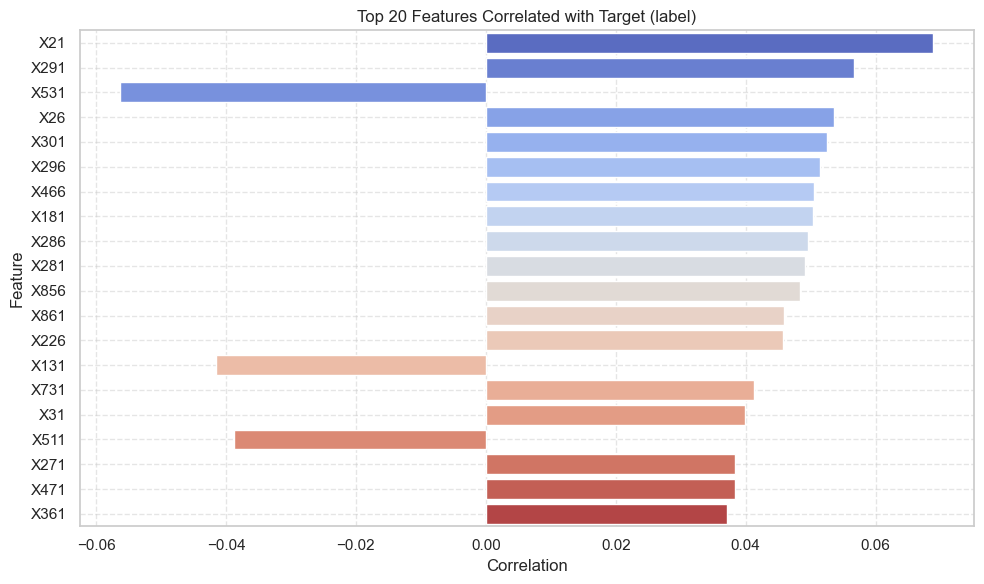

In [ ]:
corr_label = []

available_features = [f for f in sample_df.columns if f != 'label']

for f in available_features:
    valid = sample_df[['label', f]].dropna()
    if len(valid) > 10 and valid[f].nunique() > 1:
        r, p = pearsonr(valid['label'], valid[f])
        if np.isfinite(r) and p < 0.05:
            corr_label.append({
                'Feature': f,
                'Correlation': r,
                'Abs': abs(r),
                'P-value': p
            })


corr_label_df = pd.DataFrame(corr_label).sort_values('Abs', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_label_df.head(20), y='Feature', x='Correlation', palette='coolwarm')
plt.title("Top 20 Features Correlated with Target (label)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [21]:
def plot_mutual_info_scores(mi_series, label_name="label", sample_data=None, top_k=(20, 30)):
    """
    Visualizes mutual information scores with multiple plots.

    Parameters:
    - mi_series (pd.Series): Mutual information scores (sorted descending).
    - label_name (str): Name of the target variable.
    - sample_data (pd.DataFrame): Optional, used for validation.
    - top_k (tuple): Number of top features to display (barplot_1, barplot_2)
    """
    if sample_data is not None and label_name not in sample_data.columns:
        print(f"Column '{label_name}' not found in provided data.")
        return

    if mi_series is None or len(mi_series) == 0:
        print("No MI scores provided.")
        return

    print(f"\n Mutual Information Analysis for {len(mi_series)} features")

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Distribution of MI scores
    sns.histplot(mi_series.values, bins=40, kde=True, color='skyblue', ax=axs[0, 0])
    axs[0, 0].axvline(mi_series.mean(), color='darkred', linestyle='--',
                      label=f"Mean = {mi_series.mean():.4f}")
    axs[0, 0].set_title("Distribution of MI Scores")
    axs[0, 0].set_xlabel("MI Value")
    axs[0, 0].legend()

    # 2. Top-K feature barplot
    top_features = mi_series.head(top_k[0])
    sns.barplot(x=top_features.values, y=top_features.index,
                palette='coolwarm', ax=axs[0, 1])
    axs[0, 1].set_title(f"Top {top_k[0]} Features by MI Score")
    axs[0, 1].set_xlabel("MI Score")

    # 3. MI vs Feature Index
    axs[1, 0].plot(range(len(mi_series)), mi_series.values, color='seagreen')
    axs[1, 0].set_title("MI Score vs Feature Rank")
    axs[1, 0].set_xlabel("Feature Index")
    axs[1, 0].set_ylabel("Mutual Information")

    # 4. Cumulative importance
    cumulative = np.cumsum(mi_series.values)
    cumulative_pct = cumulative / cumulative[-1] * 100
    axs[1, 1].plot(range(len(cumulative_pct)), cumulative_pct, color='mediumpurple')
    for threshold, color in zip([50, 80, 95], ['red', 'orange', 'green']):
        axs[1, 1].axhline(threshold, linestyle='--', color=color, alpha=0.6, label=f'{threshold}%')
    axs[1, 1].set_title("Cumulative MI Importance")
    axs[1, 1].set_xlabel("Number of Features")
    axs[1, 1].set_ylabel("Cumulative %")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Additional barplot (top_k[1])
    plt.figure(figsize=(12, 6))
    sns.barplot(x=mi_series.head(top_k[1]).values,
                y=mi_series.head(top_k[1]).index,
                palette='viridis')
    plt.title(f"Top {top_k[1]} Features by Mutual Information")
    plt.xlabel("MI Score")
    plt.tight_layout()
    plt.show()

    print(f" Top MI feature score: {mi_series.iloc[0]:.6f}")

In [22]:

X_sample = train.drop('label', axis=1)
y_sample = train['label']

X_sample = X_sample.replace([np.inf, -np.inf], np.nan).fillna(0)

mi_scores = mutual_info_regression(X_sample, y_sample, n_neighbors=3, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X_sample.columns, name='MI_Score').sort_values(ascending=False)

print(f" Mutual Information Results:")
print(f"   Mean MI score: {mi_scores_series.mean():.6f}")
print(f"   Max MI score: {mi_scores_series.max():.6f}")
print(f"   Features with MI > 0.01: {(mi_scores_series > 0.01).sum()}")
print(f"   Features with MI > 0.05: {(mi_scores_series > 0.05).sum()}")

print(f"\n Top 10 Most Important Features:")
for i, (feature, score) in enumerate(mi_scores_series.head(10).items(), 1):
    print(f"   {i:2d}. {feature}: {score:.6f}")

 Mutual Information Results:
   Mean MI score: 0.034123
   Max MI score: 0.216761
   Features with MI > 0.01: 798
   Features with MI > 0.05: 179

 Top 10 Most Important Features:
    1. X853: 0.216761
    2. X854: 0.213776
    3. X862: 0.097195
    4. X881: 0.094666
    5. X880: 0.094134
    6. X879: 0.093998
    7. X137: 0.093643
    8. X882: 0.093016
    9. X873: 0.092330
   10. X95: 0.092239



 Mutual Information Analysis for 895 features


C:\Users\arnov\AppData\Local\Temp\ipykernel_5564\3743684057.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index,


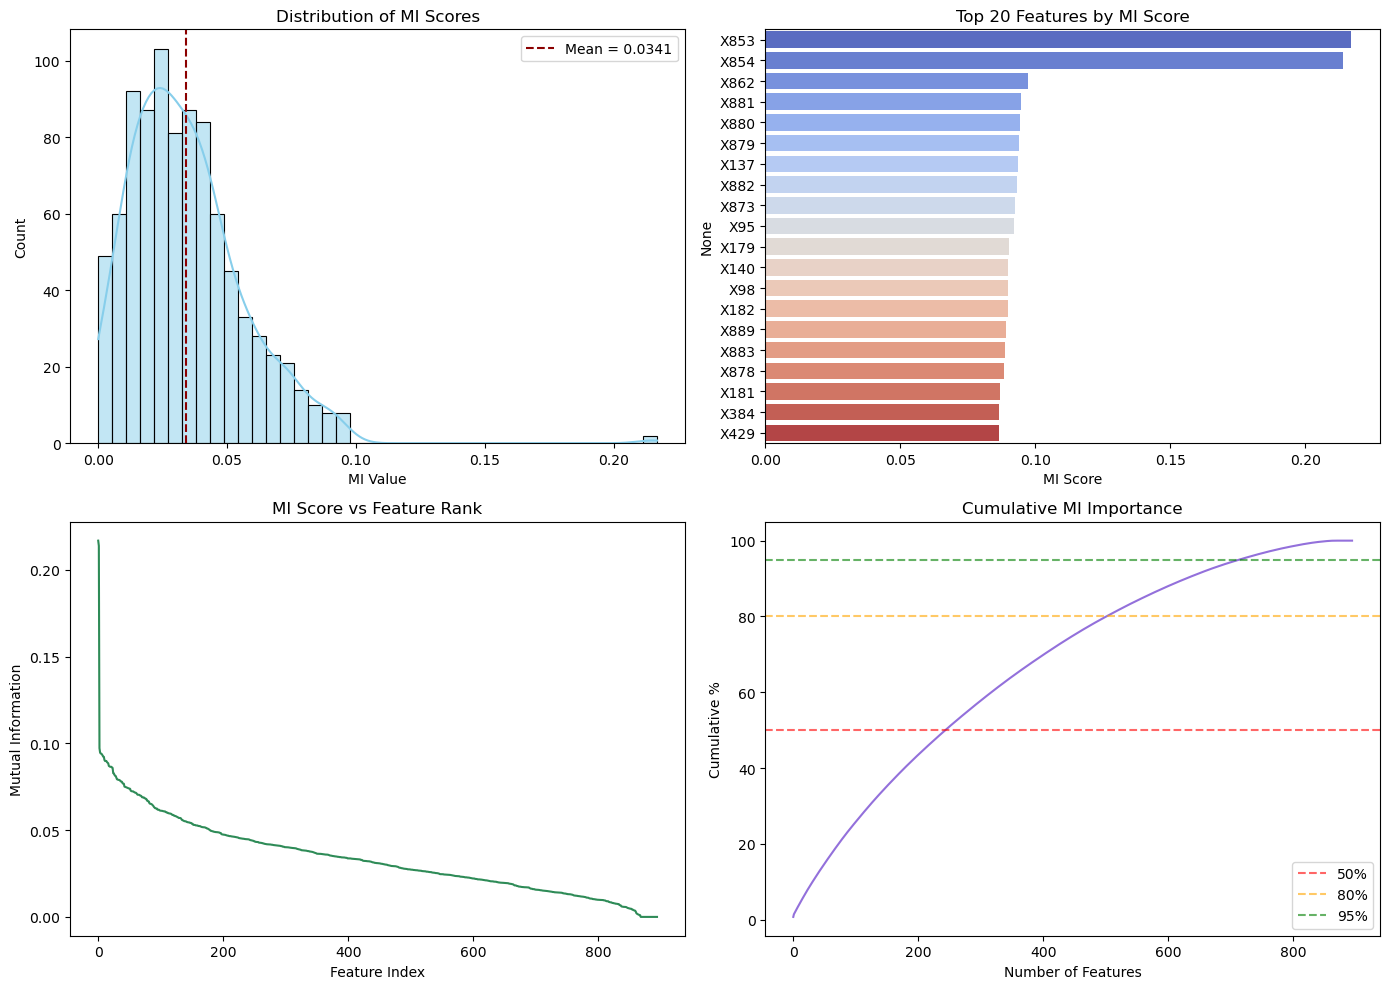

C:\Users\arnov\AppData\Local\Temp\ipykernel_5564\3743684057.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_series.head(top_k[1]).values,


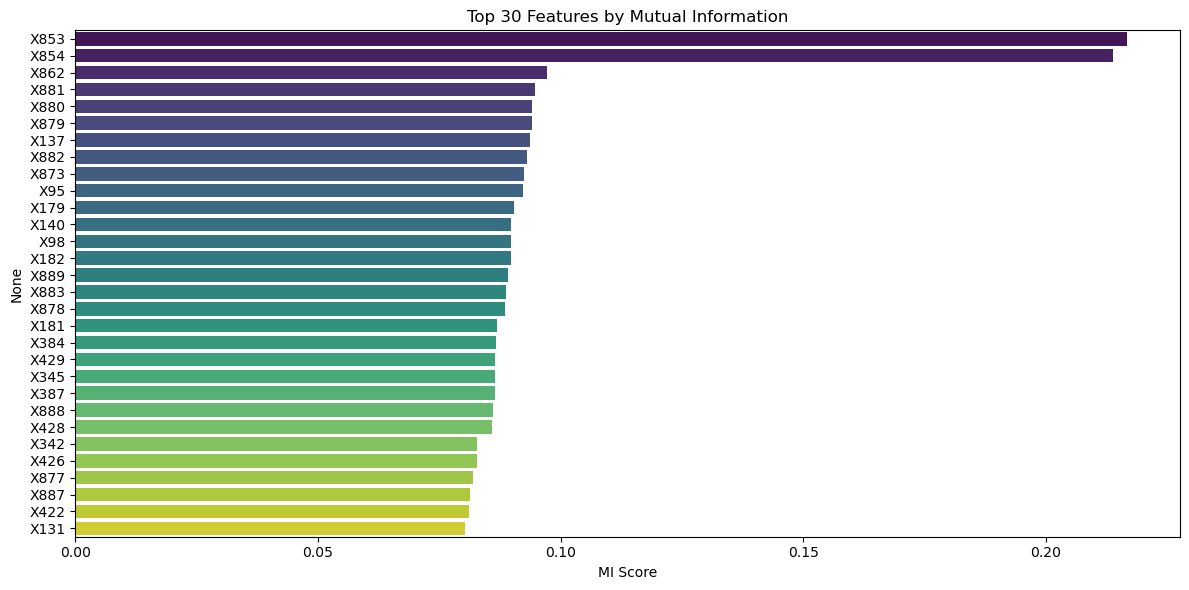

 Top MI feature score: 0.216761


In [24]:
plot_mutual_info_scores(mi_scores_series, sample_data=train)

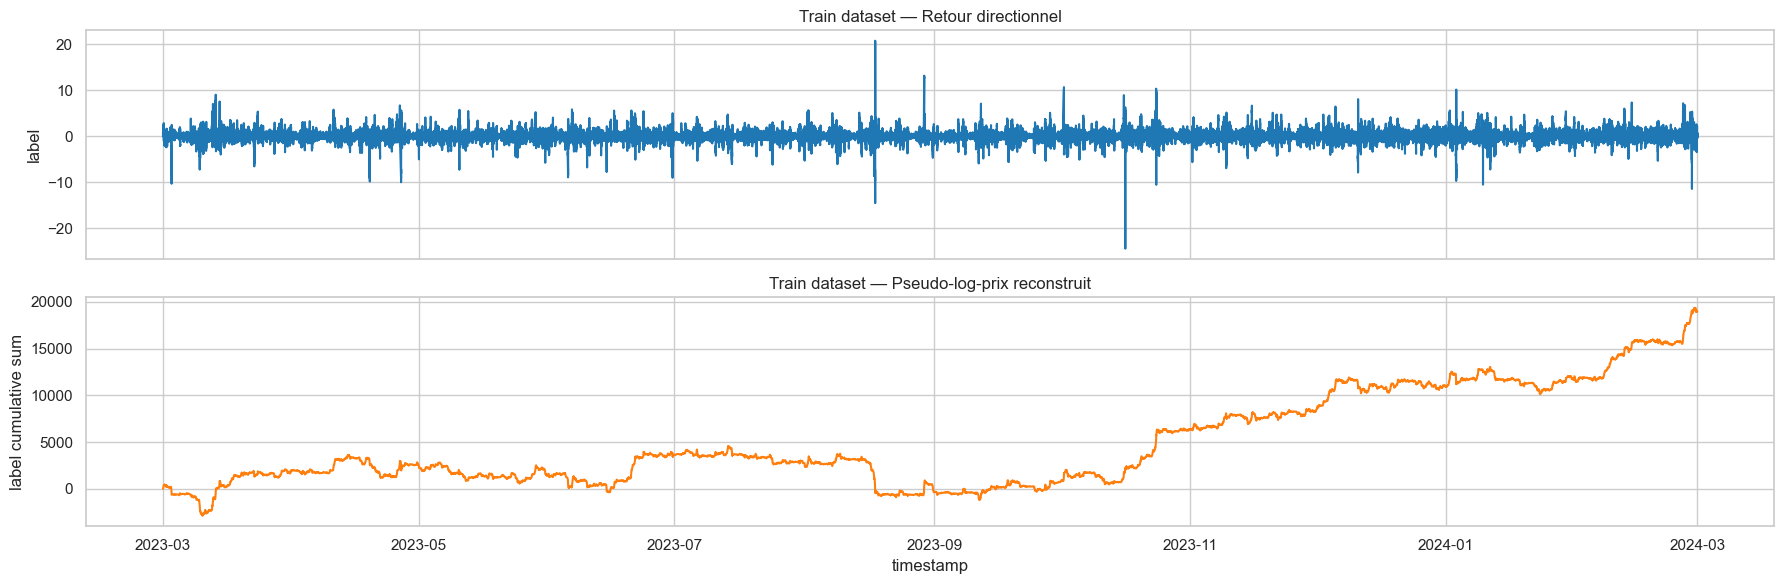

In [ ]:
target = "label"
colors = ["#1f77b4", "#ff7f0e"]  
train = train.reset_index() 
fig, ax = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

ax[0].plot(train["timestamp"], train[target], color=colors[0])
ax[0].set_ylabel(target)
ax[0].set_title("Train dataset — Directional return")

ax[1].plot(train["timestamp"], np.cumsum(train[target]), color=colors[1])
ax[1].set_xlabel("timestamp")
ax[1].set_ylabel(f"{target} cumulative sum")
ax[1].set_title("Train dataset — Reconstructed pseudo-log-price")

plt.tight_layout()
plt.show()

In [25]:
log_price = np.cumsum(train["label"])

In [26]:
log_price_clean = pd.Series(log_price).replace([np.inf, -np.inf], np.nan).dropna()

result = adfuller(log_price_clean)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The series is stationary (reject H0)")
else:
    print("The series is non-stationary (fail to reject H0)")

ADF Statistic: 1.3428955961217037
p-value: 0.9968386365275992
The series is non-stationary (fail to reject H0)


As we can see from the cumulative sum of the label, the series is not stationary( see graph and adfuller test ). Therefore, we will proceed with the original 'label' feature for further analysis.

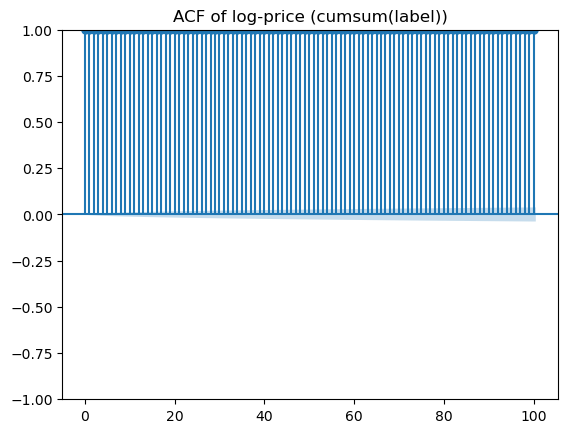

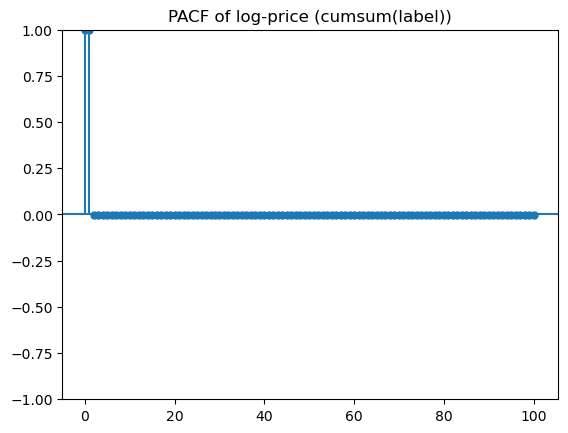

In [27]:

plot_acf(log_price_clean, lags=100)
plt.title("ACF of log-price (cumsum(label))")
plt.show()

plot_pacf(log_price_clean, lags=100)
plt.title("PACF of log-price (cumsum(label))")
plt.show()

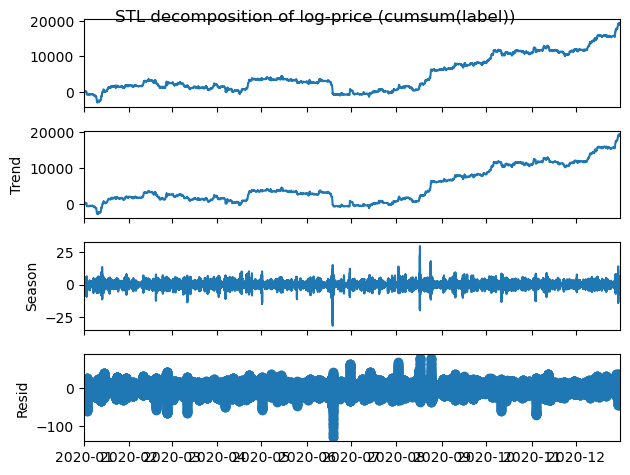

In [28]:
ts = pd.Series(log_price_clean.values, index=pd.date_range("2020-01-01", periods=len(log_price_clean), freq="min"))

stl = STL(ts, period=60) 
res = stl.fit()
res.plot()
plt.suptitle("STL decomposition of log-price (cumsum(label))")
plt.show()

In [31]:
adf_result = adfuller(train["label"].dropna())
print("ADF on label:")
print("Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF on label:
Statistic: -47.24897543425411
p-value: 0.0


The Augmented Dickey-Fuller test on the 'label' feature returns a statistic of -47.25 with a p-value of 0.0, which is well below the 0.05 threshold.
This strongly indicates that the series is stationary, and we can reject the null hypothesis of a unit root.

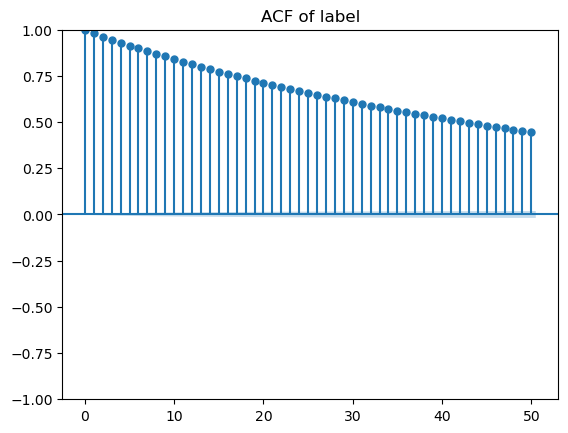

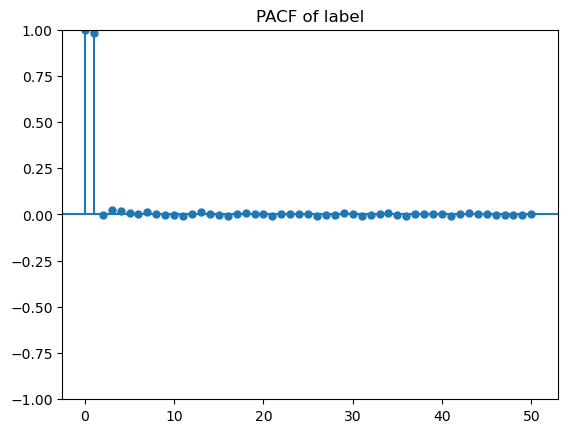

In [32]:

plot_acf(train["label"].dropna(), lags=50)
plt.title("ACF of label")
plt.show()

plot_pacf(train["label"].dropna(), lags=50)
plt.title("PACF of label")
plt.show()


ACF tails off and PACF cut offs --> AR 

In [ ]:
y = train['label'].replace([np.inf, -np.inf], np.nan).dropna()
if not isinstance(y.index, pd.DatetimeIndex):
    y = y.reset_index(drop=True)
else:
    try:
        y.index.freq = pd.infer_freq(y.index)
    except:
        y = y.reset_index(drop=True)

results = {}
print(" AR model selection:")
for p in range(1, 15):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  
        model = AutoReg(y, lags=p, old_names=False).fit()
        results[p] = model
        print(f"AR({p}) - AIC: {model.aic:.2f} | BIC: {model.bic:.2f}")


best_p = min(results, key=lambda p: results[p].aic)
best_model = results[best_p]
print(f"\n Best model: AR({best_p})")

ljung = acorr_ljungbox(best_model.resid, lags=[10], return_df=True)
print("\n Ljung-Box Test on Residuals:")
print(ljung)

if ljung["lb_pvalue"].values[0] > 0.05:
    print(" Residuals ≈ white noise → model OK")
else:
    print(" Residuals show autocorrelation → try higher p or add MA terms")


🔍 AR model selection:
AR(1) - AIC: -227358.63 | BIC: -227325.11
AR(2) - AIC: -227355.67 | BIC: -227310.97
AR(3) - AIC: -227669.12 | BIC: -227613.26
AR(4) - AIC: -227851.88 | BIC: -227784.84
AR(5) - AIC: -227901.36 | BIC: -227823.15

 Best model: AR(5)

 Ljung-Box Test on Residuals:
       lb_stat     lb_pvalue
10  100.286433  4.775736e-17
 Residuals show autocorrelation → try higher p or add MA terms


Since the residuals from the AR model still exhibit significant autocorrelation, we extend our approach to an ARIMA model to incorporate a moving average (MA) component, which may better capture the remaining dependence structure.

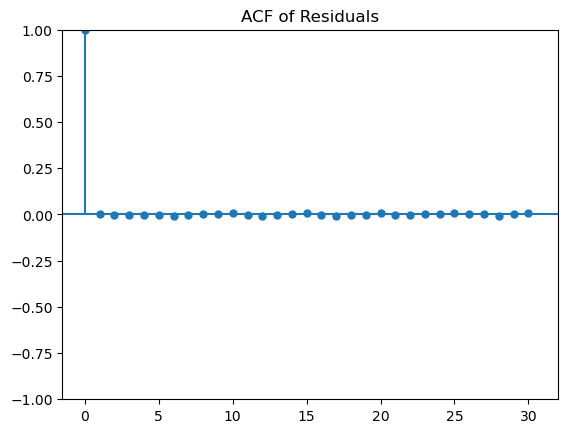

In [34]:
plot_acf(best_model.resid, lags=30)
plt.title("ACF of Residuals")
plt.show()

In [36]:
y = train['label'].replace([np.inf, -np.inf], np.nan).dropna()

if not isinstance(y.index, pd.DatetimeIndex):
    y.index = pd.RangeIndex(start=0, stop=len(y), step=1)

d = 0  # already stationary

aic_table = {}
print(" ARIMA(p, 0, q) model selection based on AIC:")

for p in range(1, 6):
    for q in range(0, 6):  
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = ARIMA(y, order=(p, d, q))
                model_fit = model.fit()
                aic_table[(p, q)] = model_fit.aic
                print(f"ARIMA({p}, {d}, {q}) - AIC: {model_fit.aic:.2f}")
        except Exception as e:
            print(f"ARIMA({p}, {d}, {q}) - failed: {type(e).__name__}")

if aic_table:
    best_order = min(aic_table, key=aic_table.get)
    print(f"\n Best ARIMA model: ARIMA{(best_order[0], d, best_order[1])} with AIC = {aic_table[best_order]:.2f}")
    best_model = ARIMA(y, order=(best_order[0], d, best_order[1])).fit()

    print("\n Model Summary:")
    print(best_model.summary())

 
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung = acorr_ljungbox(best_model.resid, lags=[10], return_df=True)
    print("\n Ljung-Box Test on Residuals:")
    print(ljung)
    
    if ljung["lb_pvalue"].values[0] > 0.05:
        print(" Residuals ≈ white noise → model is well specified.")
    else:
        print(" Residuals show autocorrelation → consider increasing p/q.")
else:
    print("\n No valid ARIMA models could be fitted.")

 ARIMA(p, 0, q) model selection based on AIC:
ARIMA(1, 0, 0) - AIC: -227356.50
ARIMA(1, 0, 1) - AIC: -227354.98
ARIMA(1, 0, 2) - AIC: -227676.35
ARIMA(1, 0, 3) - AIC: -227864.36
ARIMA(1, 0, 4) - AIC: -227913.87
ARIMA(1, 0, 5) - AIC: -227912.09
ARIMA(2, 0, 0) - AIC: -227354.96
ARIMA(2, 0, 1) - AIC: -227404.32
ARIMA(2, 0, 2) - AIC: -227895.39
ARIMA(2, 0, 3) - AIC: -227915.59
ARIMA(2, 0, 4) - AIC: -227911.84
ARIMA(2, 0, 5) - AIC: -227912.98
ARIMA(3, 0, 0) - AIC: -227669.83
ARIMA(3, 0, 1) - AIC: -227425.18
ARIMA(3, 0, 2) - AIC: -227913.39
ARIMA(3, 0, 3) - AIC: -227902.51
ARIMA(3, 0, 4) - AIC: -227922.63
ARIMA(3, 0, 5) - AIC: -227925.44
ARIMA(4, 0, 0) - AIC: -227853.17
ARIMA(4, 0, 1) - AIC: -227771.78
ARIMA(4, 0, 2) - AIC: -227914.75
ARIMA(4, 0, 3) - AIC: -227678.17
ARIMA(4, 0, 4) - AIC: -227937.99
ARIMA(4, 0, 5) - AIC: -227924.74
ARIMA(5, 0, 0) - AIC: -227904.08
ARIMA(5, 0, 1) - AIC: -227897.24
ARIMA(5, 0, 2) - AIC: -227920.20
ARIMA(5, 0, 3) - AIC: -227943.80
ARIMA(5, 0, 4) - AIC: -227940.

c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\arnov\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
 


 Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  label   No. Observations:               525887
Model:                 ARIMA(5, 0, 3)   Log Likelihood              113981.901
Date:                Wed, 11 Jun 2025   AIC                        -227943.801
Time:                        19:48:43   BIC                        -227832.073
Sample:                             0   HQIC                       -227912.238
                             - 525887                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0401      0.015      2.631      0.009       0.010       0.070
ar.L1          0.0448      0.021      2.133      0.033       0.004       0.086
ar.L2          0.8927      0.020   

In [37]:
def run_pca_analysis(df, label_col='label', explained_var_threshold=0.95, verbose=True):
    """
    Performs PCA on a dataset, targeting a cumulative explained variance.

    Parameters:
    - df (pd.DataFrame): Input dataframe including target label
    - label_col (str): Column name of the target variable
    - explained_var_threshold (float): Target cumulative variance to preserve
    - verbose (bool): If True, prints diagnostics

    Returns:
    - dict: Contains PCA model, explained variance, components, and transformed data
    """
    if label_col not in df.columns:
        raise ValueError(f"'{label_col}' column not found in dataframe.")

    X = df.drop(columns=[label_col])
    y = df[label_col]

    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_std = StandardScaler().fit_transform(X)

    if verbose:
        print(f" PCA Input: {X.shape[0]:,} samples × {X.shape[1]:,} features")

    pca = PCA(n_components=explained_var_threshold, random_state=42)
    X_pca = pca.fit_transform(X_std)

    result = {
        'pca_model': pca,
        'components_used': pca.n_components_,
        'cumulative_variance': np.sum(pca.explained_variance_ratio_),
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'X_pca': X_pca,
        'y': y.values
    }

    if verbose:
        print(f"\n PCA Summary")
        print(f" - Components selected: {pca.n_components_}")
        print(f" - Variance explained: {result['cumulative_variance']:.4f} ({explained_var_threshold:.0%} target)")

    return result


In [38]:
def plot_pca_diagnostics(pca_result, original_df, label_series, variance_target=0.95, max_display_components=20):
    """
    Visualizes PCA diagnostics from a result dict returned by `run_pca_analysis()`.

    Parameters:
        pca_result (dict): Output from run_pca_analysis()
        original_df (pd.DataFrame): Original feature dataframe (without target)
        label_series (pd.Series): Target values
        variance_target (float): Desired explained variance threshold (for display)
        max_display_components (int): Number of top components to show in scree plot
    """
    pca_obj = pca_result['pca_model']
    var_ratio = pca_result['explained_variance_ratio']
    transformed = pca_result['X_pca']
    n_components = pca_result['components_used']

    fig = plt.figure(figsize=(16, 10))

    # Plot 1: Scree plot
    ax1 = plt.subplot(2, 3, 1)
    sns.lineplot(x=np.arange(1, max_display_components + 1), y=var_ratio[:max_display_components],
                 marker='o', ax=ax1, color='dodgerblue')
    ax1.set_title("Scree Plot (Top Components)")
    ax1.set_xlabel("Component Index")
    ax1.set_ylabel("Explained Variance Ratio")
    ax1.grid(alpha=0.3)

    # Plot 2: Cumulative variance
    ax2 = plt.subplot(2, 3, 2)
    cumvar = np.cumsum(var_ratio)
    sns.lineplot(x=np.arange(1, len(cumvar)+1), y=cumvar, marker='o', ax=ax2, color='forestgreen')
    ax2.axhline(variance_target, linestyle='--', color='red', label=f'Target = {variance_target:.0%}')
    ax2.set_title("Cumulative Variance Explained")
    ax2.set_xlabel("Number of Components")
    ax2.set_ylabel("Cumulative Variance")
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Plot 3: Components required to reach thresholds
    ax3 = plt.subplot(2, 3, 3)
    thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]
    needed_components = [np.argmax(np.cumsum(var_ratio) >= t) + 1 for t in thresholds]
    sns.barplot(x=[f"{int(t*100)}%" for t in thresholds], y=needed_components, palette="crest", ax=ax3)
    ax3.set_title("Components Needed per Variance Threshold")
    ax3.set_ylabel("Components")
    ax3.set_xlabel("Threshold")
    ax3.grid(alpha=0.3)

    # Plot 4: Top PC1 loadings
    ax4 = plt.subplot(2, 3, 4)
    pc1 = pca_obj.components_[0]
    idx_top = np.argsort(np.abs(pc1))[-15:]
    feat_names = original_df.columns[idx_top]
    sns.barplot(x=pc1[idx_top], y=[f"...{col[-12:]}" for col in feat_names],
                palette="RdBu", orient='h', ax=ax4)
    ax4.set_title("Top 15 PC1 Loadings")
    ax4.set_xlabel("Loading Value")
    ax4.grid(alpha=0.3)

    # Plot 5: 2D PCA projection
    ax5 = plt.subplot(2, 3, 5)
    N = min(2000, transformed.shape[0])
    idx = np.random.choice(transformed.shape[0], N, replace=False)
    pc1_vals = transformed[idx, 0]
    pc2_vals = transformed[idx, 1] if transformed.shape[1] > 1 else np.zeros(N)
    proj_df = pd.DataFrame({
        'PC1': pc1_vals,
        'PC2': pc2_vals,
        'Label': label_series.iloc[idx].values
    })
    sns.scatterplot(data=proj_df, x='PC1', y='PC2', hue='Label',
                    palette='viridis', alpha=0.5, s=10, ax=ax5, legend=False)
    ax5.set_title("2D PCA Projection")
    ax5.set_xlabel(f"PC1 ({var_ratio[0]:.3f})")
    ax5.set_ylabel(f"PC2 ({var_ratio[1]:.3f})" if len(var_ratio) > 1 else "PC2")
    ax5.grid(alpha=0.3)

    # Plot 6: Distribution of variance explained
    ax6 = plt.subplot(2, 3, 6)
    sns.histplot(var_ratio, bins=20, kde=True, color='mediumseagreen', ax=ax6)
    for pct, color in zip([50, 75, 90, 95, 99], ['red', 'orange', 'blue', 'green', 'purple']):
        k = np.argmax(np.cumsum(var_ratio) >= pct/100) + 1
        ax6.axvline(x=var_ratio[k-1], color=color, linestyle='--', label=f'{pct}% → PC{k}')
    ax6.set_title("Variance Explained Distribution")
    ax6.set_xlabel("Explained Variance Ratio")
    ax6.set_ylabel("Component Count")
    ax6.legend(fontsize="x-small")
    ax6.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    print(f"\n PCA Diagnostic Complete")
    print(f"   → Components retained: {n_components}")
    print(f"   → Variance explained: {pca_result['cumulative_variance']:.4f}")
    reduction = (1 - n_components / original_df.shape[1]) * 100
    print(f"   → Dimensionality reduced: {original_df.shape[1]} → {n_components} ({reduction:.1f}%)")


 PCA Input: 525,887 samples × 895 features

 PCA Summary
 - Components selected: 179
 - Variance explained: 0.9504 (95% target)


C:\Users\arnov\AppData\Local\Temp\ipykernel_5564\3586053761.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"{int(t*100)}%" for t in thresholds], y=needed_components, palette="crest", ax=ax3)
C:\Users\arnov\AppData\Local\Temp\ipykernel_5564\3586053761.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pc1[idx_top], y=[f"...{col[-12:]}" for col in feat_names],


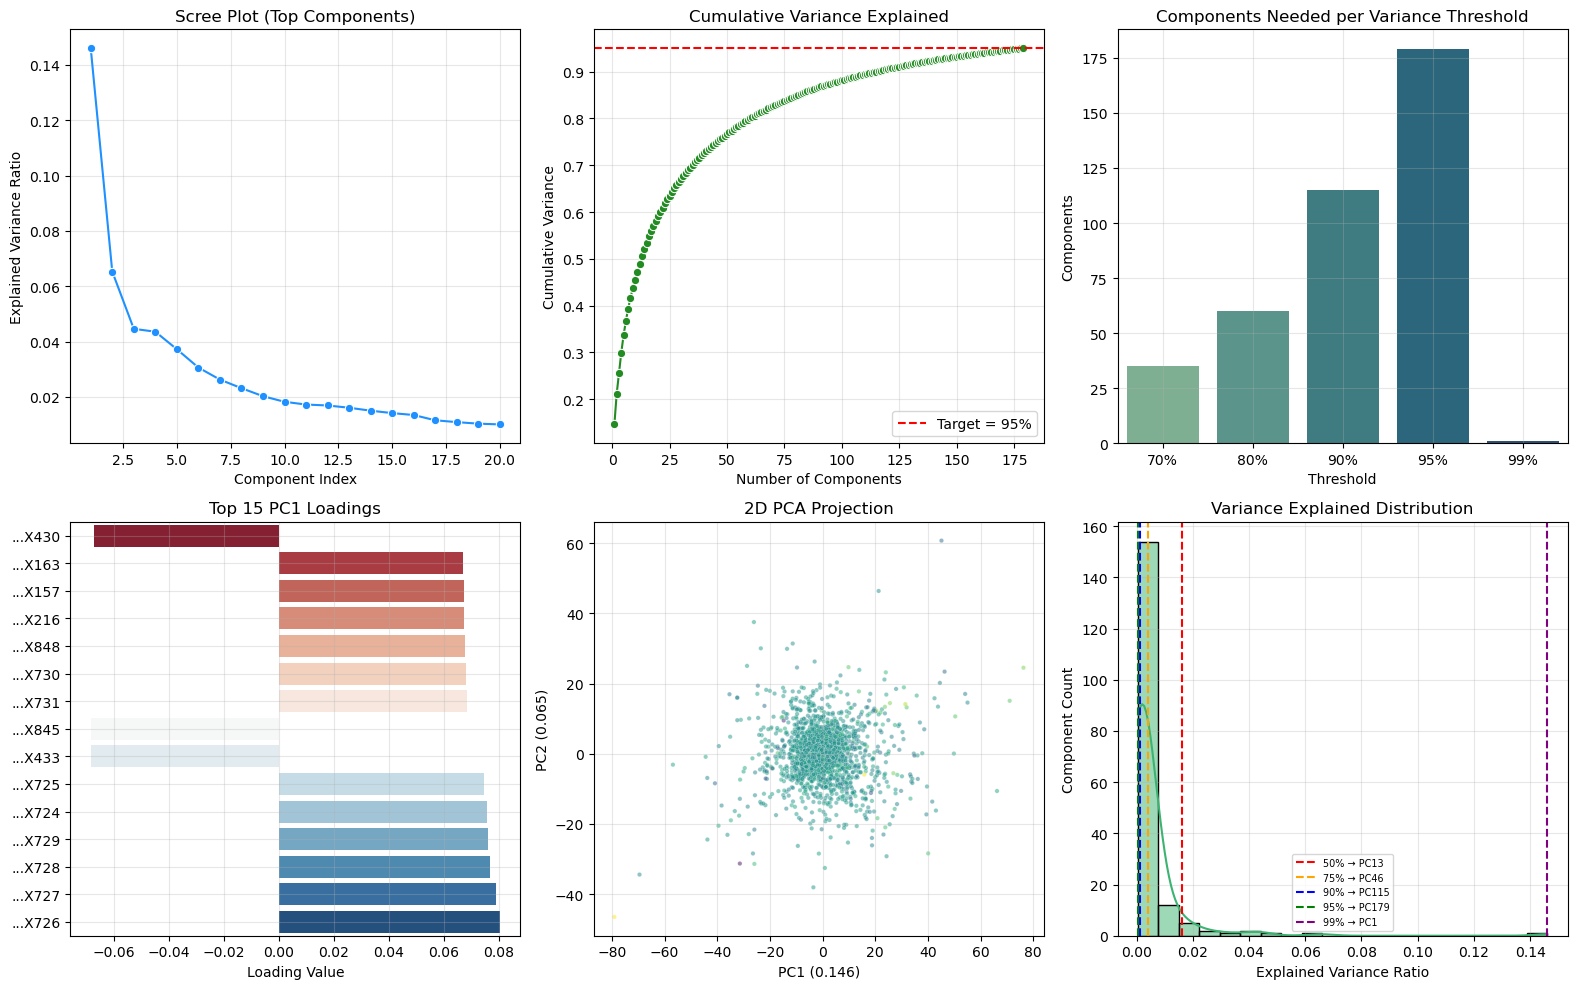


 PCA Diagnostic Complete
   → Components retained: 179
   → Variance explained: 0.9504
   → Dimensionality reduced: 895 → 179 (80.0%)


In [40]:
pca_result = run_pca_analysis(train, label_col='label', explained_var_threshold=0.95)

plot_pca_diagnostics(
    pca_result=pca_result,
    original_df=train.drop(columns='label'),
    label_series=train['label'],
    variance_target=0.95
)

***EDA Conclusion***

The dataset is of high quality, with no missing values and a rich set of features (895 predictors plus the target). The target variable label shows a shape and dynamic reminiscent of financial assets like Bitcoin, characterized by noise, volatility, and heavy tails.

Correlation analysis reveals that label is only weakly correlated with the other features. This suggests that linear relationships may not suffice to model the underlying structure, motivating the use of non-linear models such as XGBoost or LightGBM, which are well-suited to capturing complex interactions.

The Mutual Information analysis identifies several features with notable predictive power, helping to guide feature selection and dimensionality reduction. Given the high dimensionality, we also performed PCA, which allows us to capture most of the variance with a reduced set of components, improving interpretability and computational efficiency.

On the time series side, the Augmented Dickey-Fuller (ADF) test confirms that the label series is stationary. The ACF and PACF plots initially pointed toward an AR(p) model, but the Ljung-Box test on the residuals showed significant autocorrelation, indicating that a pure AR process is insufficient. We therefore move toward an ARIMA(p, 0, q) specification, introducing MA terms to better account for residual dependencies.

Overall, the data offers a solid foundation for both traditional time series modeling and modern machine learning approaches. The next step is to benchmark predictive models that integrate both linear and non-linear dynamics.